In [1]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl import edge_subgraph
from dgl.nn.functional import edge_softmax

import dgl.nn as dglnn
import dgl.function as fn

import functools
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils

print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.8a210818


In [2]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

#### load graph data

In [3]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_v1'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))


It took 11.5208 seconds to load graph


In [4]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)

usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
STATE


In [5]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.conv = dglnn.HeteroGraphConv({
#                 rel : dglnn.GraphConv(in_feat, out_feat, norm="both", weight=False, bias=False)
                rel : dglnn.SAGEConv(in_feat, out_feat, aggregator_type='mean',feat_drop=0.,bias=True,norm=None)
                for rel in rel_names
            })
        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)
        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
        self.dropout = nn.Dropout(dropout)
    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}
        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs
        hs = self.conv(g, inputs)
        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}
    

class Entity_Classify(nn.Module):
    def __init__(self,
                 g,
                 h_dim,
                 out_dim,
                 num_bases,
#                  embed_layer,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(Entity_Classify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
#         self.num_bases = None if num_bases < 0 else num_bases
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
            
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop
        
#         self.node_embed={}
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.g,self.h_dim)
#         self.node_embed['zipcode'] = Zipcode_Embedding(self.g,self.h_dim)
        self.layers = nn.ModuleList()
        #i2h
        self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout, weight=True))
        # h2h
        if self.num_hidden_layers>1:
            for i in range(0,self.num_hidden_layers-1):
                self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout))
        # h2o
#         self.layers.append(RelGraphConvLayer(
#             self.h_dim, self.out_dim, self.rel_names, 
#             self.num_bases, activation=partial(F.softmax, dim=1),
#             self_loop=self.use_self_loop))
        self.classifier = nn.Linear(self.h_dim, self.out_dim)
    
    def forward(self, input_nodes, blocks=None):
        H={}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = self.node_embed[ntype](nid)
        if blocks is None:
            for layer in self.layers:
                H = layer(self.g, H)
        else:
            for layer, block in zip(self.layers, blocks):
                H = layer(block, H)
        output = self.classifier(H["usaanr"])
    
        return output, H["usaanr"]

In [6]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def eval_loop_func(model, loader, labels, device, loss_weight, num_classes):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        seeds = seeds_raw.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].squeeze().to(device)
        
        with th.no_grad():
            logits,h = model(input_nodes,blocks)
            if loss_weight is None:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device))
            else:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device),weight=loss_weight.float())        
            losses.append(loss.item())
        fin_targets.append(lbl.cpu().detach().numpy())
        fin_outputs.append(logits.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

In [7]:
parser = argparse.ArgumentParser(description='RGCN')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument("--num_bases", type=int, default=-1,
        help="number of filter weight matrices, default: -1 [use all]")
parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--use_self_loop", default=True, action='store_true',
        help="include self feature as a special relation")
parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")


parser.add_argument("--loss_weight",  type=bool,default=True,  ## number of label=0/number of label=1
        help="weight for unbalance data")

parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()

args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=3
args.num_bases=5
args.h_dim=64
args.batch_size=1024*10
print(args)

Namespace(batch_size=10240, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, loss_weight=True, lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt', n_epochs=3, num_bases=5, num_layers=1, num_mini_batch=8, num_worker=0, out_dim=1, seed=101, use_self_loop=True, validation=True)


In [8]:
y=binary_label.squeeze().numpy()
n_classes=th.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=th.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


Text(0.5, 1.0, 'Distribution of Target Variables')

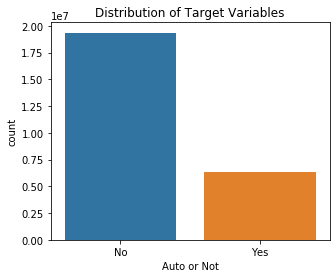

In [9]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)
plt.title("Distribution of Target Variables")

In [10]:
train_idx=th.nonzero(train_mask_binary_label.squeeze()).numpy()
val_idx=th.nonzero(val_mask_binary_label.squeeze()).numpy()
test_idx=th.nonzero(test_mask_binary_label.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze()    
val_idx=th.from_numpy(val_idx).squeeze()    
test_idx=th.from_numpy(test_idx).squeeze()

label_train=binary_label[train_idx].squeeze().numpy()
label_val=binary_label[val_idx].squeeze().numpy()
label_test=binary_label[test_idx].squeeze().numpy()


print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [11]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [12]:
num_classes=th.unique(th.from_numpy(label_train)).shape[0]
if args.loss_weight:
    train_classes_num, train_classes_weight = get_class_count_weight(label_train,num_classes)
    loss_weight=th.tensor(train_classes_weight).to(device)
else:
    loss_weight=None

In [13]:
# create model
model = Entity_Classify(G,
                       args.h_dim,
                       num_classes,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop)
if use_cuda:
    model.cuda()

model.layers

ModuleList(
  (0): RelGraphConvLayer(
    (conv): HeteroGraphConv(
      (mods): ModuleDict(
        (AUTO_RELATED): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=False)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=False)
        )
        (Brother_Sister): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=False)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=False)
        )
        (Busi_rel_Other): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=False)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=False)
        )
        (Child): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=False)
          (fc_neig

In [14]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [15]:
# train sampler
train_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, train_sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [16]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 140,990


In [17]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

node_embed.usaanr.emb.usaayr.weight                                   5,440          
node_embed.usaanr.emb.AGE_BAND.weight                                 448            
node_embed.usaanr.emb.ORIGEL.weight                                   2,752          
node_embed.usaanr.emb.ELIG2.weight                                    384            
node_embed.usaanr.emb.SEX.weight                                      320            
node_embed.usaanr.emb.MARST.weight                                    640            
node_embed.usaanr.emb.BRANCH.weight                                   1,088          
node_embed.usaanr.emb.ENLPAYGD.weight                                 1,600          
node_embed.usaanr.emb.MILST.weight                                    512            
node_embed.usaanr.emb.MLIST_OrigStat.weight                           192            
node_embed.usaanr.emb.STATE.weight                                    3,712          
layers.0.h_bias                                       

In [18]:
%pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

LOGIT_train=[]
LABEL_train=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=binary_label[seeds].to(device)       
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
    
        if args.loss_weight :
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device))
        else:
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device),weight=loss_weight.to(device))
        
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=labels_train.cpu().numpy()
                
        train_gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        
        train_acc = th.sum(logits.argmax(dim=1) == labels_train).item() / len(seeds)
        precision, recall, fscore, support = precision_recall_fscore_support(labels_train.cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

        try:
            train_auc = roc_auc_score(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        except ValueError:
            pass
        
        prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        if math.isnan(rec[0])==False:
            train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LOGIT_train.extend(logits.detach().cpu().numpy().tolist())
        LABEL_train.extend(binary_label[blocks[-1].dstnodes['usaanr'].data[dgl.NID].cpu().numpy()].tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),elapsed)) 
            
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(binary_label[blocks[-1].nodes['usaanr'].data[dgl.NID].cpu().numpy()])


    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, train_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_train=np.mean(losses_tmp)
    
    tmp_mean_pool_train=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t2=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_train, tmp_mean_pool_train["true_prediction"], tmp_mean_pool_train["false_prediction"], tmp_mean_pool_train["accuracy"], \
                                                            tmp_mean_pool_train["precision"], tmp_mean_pool_train["recall"], tmp_mean_pool_train["f1_score"], tmp_mean_pool_train["GAIN"]['10%'], \
                                                            tmp_mean_pool_train["AUC"], tmp_mean_pool_train["pr_auc"], utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, val_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_val=np.mean(losses_tmp)
    
    tmp_mean_pool_val=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t3=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_val, tmp_mean_pool_val["true_prediction"], tmp_mean_pool_val["false_prediction"], tmp_mean_pool_val["accuracy"], \
                                                            tmp_mean_pool_val["precision"], tmp_mean_pool_val["recall"], tmp_mean_pool_val["f1_score"], tmp_mean_pool_val["GAIN"]['10%'], \
                                                            tmp_mean_pool_val["AUC"], tmp_mean_pool_val["pr_auc"], utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)
    
avg_loss_test=np.mean(losses_tmp)

tmp_mean_pool_test=evaluate(fin_targets.reshape(-1),fin_outputs)

t4=time.time()

print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_test, tmp_mean_pool_test["true_prediction"], tmp_mean_pool_test["false_prediction"], tmp_mean_pool_test["accuracy"], \
                                                        tmp_mean_pool_test["precision"], tmp_mean_pool_test["recall"], tmp_mean_pool_test["f1_score"], tmp_mean_pool_test["GAIN"]['10%'], \
                                                        tmp_mean_pool_test["AUC"], tmp_mean_pool_test["pr_auc"], utils.format_time(t4-t3)))


  0%|          | 0/3 [00:00<?, ?it/s]

Automatic pdb calling has been turned ON
start training...

========= Epoch 1 /3
Training...
Batch 200 of 2006 | Loss 0.394  | Elapsed: 0:01:23
Batch 400 of 2006 | Loss 0.378  | Elapsed: 0:02:33
Batch 600 of 2006 | Loss 0.372  | Elapsed: 0:03:33
Batch 800 of 2006 | Loss 0.368  | Elapsed: 0:04:35
Batch 1000 of 2006 | Loss 0.368  | Elapsed: 0:05:44
Batch 1200 of 2006 | Loss 0.365  | Elapsed: 0:06:46
Batch 1400 of 2006 | Loss 0.364  | Elapsed: 0:07:47
Batch 1600 of 2006 | Loss 0.362  | Elapsed: 0:08:45
Batch 1800 of 2006 | Loss 0.361  | Elapsed: 0:09:48
Batch 2000 of 2006 | Loss 0.362  | Elapsed: 0:10:27


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 1/251 [00:00<00:29,  8.36it/s]

avg_loss: 0.54 | True_Prediction: 16,941,531 | False_Prediction: 3,593,273 | accuracy: 82.50% |  precision: 71.21% | recall: 48.36% | F1_score: 57.61% | Gain_top-10%: 0.3 |    ROC_AUC: 87.7% | PR_AUC: 68.6% | Elapsed: 0:06:54


Running Validation on validation set



 33%|███▎      | 1/3 [17:57<35:55, 1077.86s/it]

avg_loss: 0.54 | True_Prediction: 2,117,882 | False_Prediction: 448,968 | accuracy: 82.51% |  precision: 71.23% | recall: 48.39% | F1_score: 57.63% | Gain_top-10%: 0.3 |    ROC_AUC: 87.7% | PR_AUC: 68.6% | Elapsed: 0:00:38

========= Epoch 2 /3
Training...
Batch 200 of 2006 | Loss 0.361  | Elapsed: 0:00:52
Batch 400 of 2006 | Loss 0.361  | Elapsed: 0:01:38
Batch 600 of 2006 | Loss 0.360  | Elapsed: 0:02:32
Batch 800 of 2006 | Loss 0.361  | Elapsed: 0:03:30
Batch 1000 of 2006 | Loss 0.356  | Elapsed: 0:04:15
Batch 1200 of 2006 | Loss 0.357  | Elapsed: 0:05:20
Batch 1400 of 2006 | Loss 0.357  | Elapsed: 0:06:05
Batch 1600 of 2006 | Loss 0.358  | Elapsed: 0:07:15
Batch 1800 of 2006 | Loss 0.360  | Elapsed: 0:08:01
Batch 2000 of 2006 | Loss 0.357  | Elapsed: 0:09:14


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 1/251 [00:00<00:27,  9.03it/s]

avg_loss: 0.51 | True_Prediction: 17,007,716 | False_Prediction: 3,527,088 | accuracy: 82.82% |  precision: 69.80% | recall: 53.11% | F1_score: 60.32% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.8% | Elapsed: 0:05:44


Running Validation on validation set



 67%|██████▋   | 2/3 [34:18<17:28, 1048.74s/it]

avg_loss: 0.51 | True_Prediction: 2,126,122 | False_Prediction: 440,728 | accuracy: 82.83% |  precision: 69.83% | recall: 53.09% | F1_score: 60.32% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.9% | Elapsed: 0:00:39

========= Epoch 3 /3
Training...
Batch 200 of 2006 | Loss 0.357  | Elapsed: 0:00:56
Batch 400 of 2006 | Loss 0.361  | Elapsed: 0:01:35
Batch 600 of 2006 | Loss 0.356  | Elapsed: 0:02:24
Batch 800 of 2006 | Loss 0.356  | Elapsed: 0:03:10
Batch 1000 of 2006 | Loss 0.354  | Elapsed: 0:03:53
Batch 1200 of 2006 | Loss 0.355  | Elapsed: 0:04:57
Batch 1400 of 2006 | Loss 0.359  | Elapsed: 0:05:43
Batch 1600 of 2006 | Loss 0.359  | Elapsed: 0:06:31
Batch 1800 of 2006 | Loss 0.357  | Elapsed: 0:07:50
Batch 2000 of 2006 | Loss 0.354  | Elapsed: 0:08:36


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  1%|          | 2/251 [00:00<00:22, 11.01it/s]

avg_loss: 0.52 | True_Prediction: 17,007,155 | False_Prediction: 3,527,649 | accuracy: 82.82% |  precision: 70.07% | recall: 52.57% | F1_score: 60.07% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.8% | Elapsed: 0:06:02


Running Validation on validation set



  0%|          | 1/251 [00:00<00:26,  9.56it/s]

avg_loss: 0.52 | True_Prediction: 2,126,302 | False_Prediction: 440,548 | accuracy: 82.84% |  precision: 70.12% | recall: 52.59% | F1_score: 60.10% | Gain_top-10%: 0.3 |    ROC_AUC: 88.2% | PR_AUC: 69.9% | Elapsed: 0:00:34


Running Validation in Test Dataset



100%|██████████| 251/251 [00:24<00:00, 10.10it/s]


avg_loss: 0.52 | True_Prediction: 2,126,762 | False_Prediction: 440,088 | accuracy: 82.85% |  precision: 70.13% | recall: 52.69% | F1_score: 60.17% | Gain_top-10%: 0.3 |ROC_AUC: 88.2% | PR_AUC: 69.9% | Elapsed: 0:00:37


In [19]:
tmp_mean_pool_train

{'nb_example': 20534804,
 'true_prediction': 17007155,
 'false_prediction': 3527649,
 'accuracy': 0.8282112164304076,
 'precision': 0.7007099739133972,
 'recall': 0.52565231543327,
 'f1_score': 0.6006868010121017,
 'AUC': 0.8821407554475487,
 'pr_auc': 0.6979343866696794,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [20]:
tmp_mean_pool_val

{'nb_example': 2566850,
 'true_prediction': 2126302,
 'false_prediction': 440548,
 'accuracy': 0.8283701813506827,
 'precision': 0.7011869768542683,
 'recall': 0.5258899548148136,
 'f1_score': 0.6010172272948745,
 'AUC': 0.8820582097014448,
 'pr_auc': 0.6985765214731281,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [21]:
tmp_mean_pool_test

{'nb_example': 2566850,
 'true_prediction': 2126762,
 'false_prediction': 440088,
 'accuracy': 0.8285493893293336,
 'precision': 0.7013097139048206,
 'recall': 0.5269312269101479,
 'f1_score': 0.6017418500097734,
 'AUC': 0.8823399072452234,
 'pr_auc': 0.6986180439098791,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

#### model save

In [22]:
if not os.path.exists("model_save"):
    os.makedirs("model_save")
model.save_model("model_save/GraphSage")

ModuleAttributeError: 'Entity_Classify' object has no attribute 'save_model'

> /opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py(772)__getattr__()
    770                 return modules[name]
    771         raise ModuleAttributeError("'{}' object has no attribute '{}'".format(
--> 772             type(self).__name__, name))
    773 
    774     def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:



ipdb>  q


#### Score Test Dataset

In [23]:
%%time
fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)

savez_compressed("model_save/GraphSage_LOGIT.npz", fin_outputs)
savez_compressed("model_save/GraphSage_LABEL.npz", fin_targets)

# os.system("rm model_save/HGT_LOGIT.npz")
# os.system("rm model_save/HGT_LABEL.npz")

fin_logits = load("model_save/GraphSage_LOGIT.npz")['arr_0']
fin_targets = load("model_save/GraphSage_LABEL.npz")['arr_0']

tmp_test=evaluate(fin_targets.reshape(-1),fin_logits)

print("")
print("==> Running Validation on validation set \n")
print("")

print("True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%}".format(tmp_test["true_prediction"], tmp_test["false_prediction"], tmp_test["accuracy"], \
                                                        tmp_test["precision"], tmp_test["recall"], tmp_test["f1_score"], tmp_test["GAIN"]['10%'], \
                                                        tmp_test["AUC"], tmp_test["pr_auc"]))

100%|██████████| 251/251 [00:22<00:00, 11.20it/s]



==> Running Validation on validation set 


True_Prediction: 2,126,762 | False_Prediction: 440,088 | accuracy: 82.85% |  precision: 70.13% | recall: 52.69% | F1_score: 60.17% | Gain_top-10%: 0.3 |ROC_AUC: 88.2% | PR_AUC: 69.9%
CPU times: user 1min, sys: 2.82 s, total: 1min 3s
Wall time: 36.8 s
